In [2]:
import pandas as pd
import sqlite3
from sqlalchemy import create_engine

print("--- [สร้างฐานข้อมูล] ---")

full_csv_filename = 'GlobalFoodPricesFull.csv'
db_filename = 'global_food_prices.db'
table_name = 'food_prices'

try:
    print(f"กำลังอ่านไฟล์ CSV ขนาดใหญ่: {full_csv_filename}...")
    df_full = pd.read_csv(full_csv_filename, low_memory=False)
    
    print(f"อ่านไฟล์สำเร็จ มี {len(df_full)} แถว")
    
    engine = create_engine(f'sqlite:///{db_filename}')
    
    print(f"กำลังเขียนข้อมูลลงตาราง '{table_name}' ในฐานข้อมูล '{db_filename}'...")
    df_full.to_sql(table_name, engine, index=False, if_exists='replace')
    
    print(f"สร้างตาราง '{table_name}' สำเร็จ!")
    
except FileNotFoundError:
    print(f"!!! ข้อผิดพลาด: ไม่พบไฟล์ '{full_csv_filename}'")
except Exception as e:
    print(f"เกิดข้อผิดพลาดระหว่างสร้างฐานข้อมูล: {e}")

--- [สร้างฐานข้อมูล] ---
กำลังอ่านไฟล์ CSV ขนาดใหญ่: GlobalFoodPricesFull.csv...
อ่านไฟล์สำเร็จ มี 3109617 แถว
กำลังเขียนข้อมูลลงตาราง 'food_prices' ในฐานข้อมูล 'global_food_prices.db'...
สร้างตาราง 'food_prices' สำเร็จ!


In [3]:
import pandas as pd
import sqlite3
import numpy as np
import warnings

warnings.filterwarnings('ignore')

print("--- [ขั้นตอนที่ 1 & 2] (ฉบับใหม่: กรองเฉพาะ 'Wheat flour') ---")

db_filename = 'global_food_prices.db'
table_name = 'food_prices'

commodity_to_analyze = 'Wheat flour'

query = f"""
    SELECT 
        date, 
        country_code, 
        market, 
        commodity, 
        price_usd,
        category,
        unit 
    FROM {table_name}
    WHERE 
        price_type = 'Retail' 
        AND commodity = '{commodity_to_analyze}'
        AND price_flag = 'actual'
"""

print(f"กำลังเชื่อมต่อกับ '{db_filename}' และดึงข้อมูลเฉพาะ '{commodity_to_analyze}'...")

try:
    conn = sqlite3.connect(db_filename)
    df = pd.read_sql(query, conn) 
    conn.close()
    
    print(f"ดึงข้อมูลสำเร็จ! ได้ข้อมูลมา {len(df)} แถว")

    rows_before = len(df)
    df.dropna(subset=['price_usd'], inplace=True)
    rows_after = len(df)
    print(f"[Pre-processing 1] ลบแถวที่ 'price_usd' เป็นค่าว่าง: ลบไป {rows_before - rows_after} แถว")

    df['date'] = pd.to_datetime(df['date'])
    print("[Pre-processing 2] แปลงคอลัมน์ 'date' เป็นชนิด datetime สำเร็จ")

    print("\n--- ข้อมูล 'หลัง' การทำความสะอาด (พร้อมใช้งาน) ---")
    print(df.info())
    print("\n--- ตรวจสอบสินค้า (Wheat flour) ---")
    print(f"สินค้าทั้งหมดที่ดึงมา: {df['commodity'].nunique()} ชนิด")
    print(df['commodity'].unique())


except Exception as e:
    print(f"!!! เกิดข้อผิดพลาด: {e}")

--- [ขั้นตอนที่ 1 & 2] (ฉบับใหม่: กรองเฉพาะ 'Wheat flour') ---
กำลังเชื่อมต่อกับ 'global_food_prices.db' และดึงข้อมูลเฉพาะ 'Wheat flour'...
ดึงข้อมูลสำเร็จ! ได้ข้อมูลมา 46887 แถว
[Pre-processing 1] ลบแถวที่ 'price_usd' เป็นค่าว่าง: ลบไป 38 แถว
[Pre-processing 2] แปลงคอลัมน์ 'date' เป็นชนิด datetime สำเร็จ

--- ข้อมูล 'หลัง' การทำความสะอาด (พร้อมใช้งาน) ---
<class 'pandas.core.frame.DataFrame'>
Index: 46849 entries, 0 to 46886
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          46849 non-null  datetime64[ns]
 1   country_code  46849 non-null  object        
 2   market        46849 non-null  object        
 3   commodity     46849 non-null  object        
 4   price_usd     46849 non-null  float64       
 5   category      46849 non-null  object        
 6   unit          46849 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 2.9+ MB
None

--- ตรวจสอบ

In [4]:
# --- [ขั้นตอนที่ 2.5] การแปลงหน่วย (Unit Normalization) ---
import re  # <-- [ 🔴 แก้ไข 🔴 ] เพิ่มบรรทัดนี้

print("\n--- [ขั้นตอนที่ 2.5] เริ่มการแปลงหน่วย (Unit Normalization) ---")

try:
    # 1. ตรวจสอบค่า 'unit' ที่มีทั้งหมด
    print("ตรวจสอบค่า 'unit' ที่มีในข้อมูล 'Wheat flour':")
    print(df['unit'].unique())

    # 2. สร้างฟังก์ชันแปลงหน่วย
    def get_kg_multiplier(unit_str):
        unit_str = str(unit_str).upper()
        
        # ลบช่องว่าง
        unit_str = re.sub(r'\s+', '', unit_str)
        
        # กรณี "KG" หรือ "1KG" (ถือเป็น 1 KG)
        if unit_str == 'KG' or unit_str == '1KG':
            return 1.0
        
        # กรณี "G" หรือ "GRAM" (เช่น 900G)
        if 'G' in unit_str and 'KG' not in unit_str:
            value = re.findall(r"[\d\.]+", unit_str)
            if value:
                return float(value[0]) / 1000.0 # แปลง G เป็น KG
        
        # กรณี "KG" (เช่น 1.5KG, 50KG)
        if 'KG' in unit_str:
            value = re.findall(r"[\d\.]+", unit_str)
            if value:
                return float(value[0])
                
        # กรณีอื่นๆ ที่ไม่รองรับ (เช่น ML, L, Pcs)
        return None

    # 3. สร้างคอลัมน์ 'kg_multiplier'
    df['kg_multiplier'] = df['unit'].apply(get_kg_multiplier)
    
    rows_before = len(df)
    
    # 4. ลบแถวที่ไม่สามารถแปลงหน่วยได้ (เช่น ML, Pcs, หรือค่าว่าง)
    df.dropna(subset=['kg_multiplier'], inplace=True)
    
    rows_after = len(df)
    print(f"[Normalization 1] ลบแถวที่ไม่สามารถแปลงหน่วย (kg_multiplier) ได้: ลบไป {rows_before - rows_after} แถว")

    # 5. สร้างคอลัมน์ใหม่ 'price_per_kg'
    df['price_per_kg'] = df['price_usd'] / df['kg_multiplier']
    
    print("[Normalization 2] สร้างคอลัมน์ 'price_per_kg' สำเร็จ!")
    
    # (ตรวจสอบ) แสดงผล 5 แถวตัวอย่าง
    print("\n--- ตัวอย่างข้อมูลหลังการ Normalization ---")
    print(df[['unit', 'price_usd', 'kg_multiplier', 'price_per_kg']].sample(500))

except Exception as e:
    print(f"!!! เกิดข้อผิดพลาดระหว่างการแปลงหน่วย: {e}")


--- [ขั้นตอนที่ 2.5] เริ่มการแปลงหน่วย (Unit Normalization) ---
ตรวจสอบค่า 'unit' ที่มีในข้อมูล 'Wheat flour':
['KG' '100 KG' '50 KG' '12.5 KG' '1.5 KG' '60 KG' '900 G']
[Normalization 1] ลบแถวที่ไม่สามารถแปลงหน่วย (kg_multiplier) ได้: ลบไป 0 แถว
[Normalization 2] สร้างคอลัมน์ 'price_per_kg' สำเร็จ!

--- ตัวอย่างข้อมูลหลังการ Normalization ---
      unit  price_usd  kg_multiplier  price_per_kg
33812   KG       0.38            1.0          0.38
23453   KG       0.58            1.0          0.58
30246   KG       0.56            1.0          0.56
7692    KG       0.90            1.0          0.90
36394   KG       0.38            1.0          0.38
...    ...        ...            ...           ...
29151   KG       0.45            1.0          0.45
27511   KG       0.72            1.0          0.72
13784   KG       0.48            1.0          0.48
14043   KG       1.28            1.0          1.28
36537   KG       0.43            1.0          0.43

[500 rows x 4 columns]


In [5]:
print("\n--- [ขั้นตอนที่ 3] เริ่มต้นการทำ Feature Engineering ---")

import re 

try:

    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Quarter'] = df['date'].dt.quarter
    print("[Feature Eng. 1] สร้างตัวแปร Year, Month, Quarter สำเร็จ")

    features_to_encode = ['country_code'] 
    # ------------------------
    
    print(f"[Feature Eng. 2] กำลังแปลง {features_to_encode} ด้วย One-Hot Encoding...")
    
    df_encoded = pd.get_dummies(df, columns=features_to_encode, drop_first=True)
    print("[Feature Eng. 2] แปลง One-Hot Encoding สำเร็จ")

    y = df_encoded['price_per_kg']
    
    X = df_encoded.drop(columns=[
        'date',
        'market',
        'price_usd',
        'commodity', 
        'category',
        'unit',           
        'kg_multiplier',  
        'price_per_kg'    
    ])
    
    print("[Feature Eng. 3] กำลังล้าง (Sanitize) ชื่อคอลัมน์สำหรับ LightGBM...")
    
    X.columns = [re.sub(r'[\\[\\]()<,]', '_', col) for col in X.columns]
    
    print("[Feature Eng. 3] ล้างชื่อคอลัมน์สำเร็จ!")

    print("\n--- Feature Engineering เสร็จสิ้น! ---")
    print("โครงสร้าง Features (X) ทั้งหมด:")
    X.info()

except Exception as e:
    print(f"!!! เกิดข้อผิดพลาดระหว่างทำ Feature Engineering: {e}")


--- [ขั้นตอนที่ 3] เริ่มต้นการทำ Feature Engineering ---
[Feature Eng. 1] สร้างตัวแปร Year, Month, Quarter สำเร็จ
[Feature Eng. 2] กำลังแปลง ['country_code'] ด้วย One-Hot Encoding...
[Feature Eng. 2] แปลง One-Hot Encoding สำเร็จ
[Feature Eng. 3] กำลังล้าง (Sanitize) ชื่อคอลัมน์สำหรับ LightGBM...
[Feature Eng. 3] ล้างชื่อคอลัมน์สำเร็จ!

--- Feature Engineering เสร็จสิ้น! ---
โครงสร้าง Features (X) ทั้งหมด:
<class 'pandas.core.frame.DataFrame'>
Index: 46849 entries, 0 to 46886
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Year              46849 non-null  int32
 1   Month             46849 non-null  int32
 2   Quarter           46849 non-null  int32
 3   country_code_ARG  46849 non-null  bool 
 4   country_code_ARM  46849 non-null  bool 
 5   country_code_AZE  46849 non-null  bool 
 6   country_code_BGD  46849 non-null  bool 
 7   country_code_BLR  46849 non-null  bool 
 8   country_code_BOL  46849 non-nul

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

print("\n--- [ขั้นตอนที่ 4] (ฉบับอัปเกรด: ทดลอง 5 โมเดล) ---")

try:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"แบ่งข้อมูล: {len(X_train)} แถวสำหรับ Train, {len(X_test)} แถวสำหรับ Test")

    models = {
        "1. Linear Regression": LinearRegression(),
        "2. Ridge Regression": Ridge(random_state=42),
        "3. Decision Tree": DecisionTreeRegressor(random_state=42),
        "4. Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
        "5. LightGBM (LGBM)": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    }

    model_names = []
    r2_scores = []
    mae_scores = []

    for name, model in models.items():
        print(f"\nกำลังเทรนโมเดล: {name}...")
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        model_names.append(name)
        r2_scores.append(r2)
        mae_scores.append(mae)
        
        print(f"ผลลัพธ์ {name}: R-squared = {r2:.4f}, MAE = {mae:.4f}")

    print("\n--- ตารางเปรียบเทียบประสิทธิภาพโมเดล (Scoreboard) ---")
    
    scoreboard = pd.DataFrame({
        'Algorithm': model_names,
        'R-squared': r2_scores,
        'Mean Absolute Error (MAE)': mae_scores
    })
    
    scoreboard_sorted = scoreboard.sort_values(by='R-squared', ascending=False)
    
    print(scoreboard_sorted)
    
    print("\n--- [Dynamic] การบันทึกผลลัพธ์ Baseline อัตโนมัติ ---")
    
    best_model_row = scoreboard_sorted.iloc[0]
    
    best_model_name = best_model_row['Algorithm']
    baseline_r2 = best_model_row['R-squared']
    baseline_mae = best_model_row['Mean Absolute Error (MAE)']
    
    print(f"โมเดลที่ดีที่สุดคือ: {best_model_name}")
    print(f"กำลังส่งค่า R2={baseline_r2:.4f}, MAE={baseline_mae:.4f} ไปยังขั้นตอนที่ 5...")

except Exception as e:
    print(f"!!! เกิดข้อผิดพลาดระหว่างการเทรนโมเดล: {e}")


--- [ขั้นตอนที่ 4] (ฉบับอัปเกรด: ทดลอง 5 โมเดล) ---
แบ่งข้อมูล: 37479 แถวสำหรับ Train, 9370 แถวสำหรับ Test

กำลังเทรนโมเดล: 1. Linear Regression...
ผลลัพธ์ 1. Linear Regression: R-squared = 0.5892, MAE = 0.3700

กำลังเทรนโมเดล: 2. Ridge Regression...
ผลลัพธ์ 2. Ridge Regression: R-squared = 0.5888, MAE = 0.3716

กำลังเทรนโมเดล: 3. Decision Tree...
ผลลัพธ์ 3. Decision Tree: R-squared = 0.8922, MAE = 0.1727

กำลังเทรนโมเดล: 4. Random Forest...
ผลลัพธ์ 4. Random Forest: R-squared = 0.9106, MAE = 0.1701

กำลังเทรนโมเดล: 5. LightGBM (LGBM)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 37479, number of used features: 54
[LightGBM] [Info] Start training from score 1.039594
ผลลัพธ์ 5. LightGBM (LGBM): R-squared = 0.8959, MA

In [7]:
from sklearn.model_selection import GridSearchCV

print("\n--- [ขั้นตอนที่ 5] เริ่มต้นการปรับปรุงพารามิเตอร์ (Fine-tuning) ---")
try:
    print(f"เราจะจูนโมเดล: '{best_model_name}' (ที่รับค่ามาจากขั้นตอนที่ 4)")
    print(f"Baseline (จากขั้นตอนที่ 4): R2={baseline_r2:.4f}, MAE={baseline_mae:.4f}")
except NameError:
    print("!!! ไม่พบตัวแปร best_model_name !!!")
    print("!!! กรุณารัน Cell ที่ 3 (ขั้นตอนที่ 4) ก่อน!!!")
    raise

estimator_blueprints = {
    "1. Linear Regression": LinearRegression(),
    "2. Ridge Regression": Ridge(random_state=42),
    "3. Decision Tree": DecisionTreeRegressor(random_state=42),
    "4. Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "5. LightGBM (LGBM)": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}

param_grids = {
    "1. Linear Regression": {},
    "2. Ridge Regression": {
        'alpha': [0.5, 1.0, 5.0] 
    },
    "3. Decision Tree": {
        'max_depth': [10, 20, None],
        'min_samples_leaf': [1, 5, 10]
    },
    "4. Random Forest": {
        'n_estimators': [100, 200], 
        'max_depth': [10, 20, None]
    },
    "5. LightGBM (LGBM)": {
        'num_leaves': [31, 50],
        'n_estimators': [100, 200]
    }
}

estimator_to_tune = estimator_blueprints[best_model_name]
param_grid_to_use = param_grids[best_model_name]

if not param_grid_to_use:
    print(f"\nโมเดล '{best_model_name}' ไม่จำเป็นต้อง/ไม่สามารถ Fine-tune ได้")
    
else:
    grid_search = GridSearchCV(
        estimator=estimator_to_tune, 
        param_grid=param_grid_to_use, 
        cv=3, 
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1 # 
    )

    print(f"\nกำลังเริ่ม GridSearchCV สำหรับ '{best_model_name}'...")
    
    grid_search.fit(X_train, y_train)

    print("GridSearchCV เสร็จสิ้น!")
    
    print(f"\nParameters ที่ดีที่สุดที่ค้นพบ: {grid_search.best_params_}")

    best_tuned_model = grid_search.best_estimator_
    y_pred_tuned = best_tuned_model.predict(X_test)
    
    tuned_r2 = r2_score(y_test, y_pred_tuned)
    tuned_mae = mean_absolute_error(y_test, y_pred_tuned)

    print("\n--- สรุปผลการ Fine-tuning ---")
    print(f"Baseline (โมเดลเดิม): R2={baseline_r2:.4f}, MAE={baseline_mae:.4f}")
    print(f"Tuned (โมเดลใหม่):   R2={tuned_r2:.4f}, MAE={tuned_mae:.4f}")

    mae_improvement_percent = ((baseline_mae - tuned_mae) / baseline_mae) * 100
    
    print("\n--- ผลลัพธ์สำหรับนำเสนอ (ข้อ 5) ---")
    if tuned_mae < baseline_mae:
        print(f"สรุป: เราปรับปรุงโมเดล 1 ตัว ({best_model_name}) ได้สำเร็จ")
        print(f"ประสิทธิภาพดีขึ้น โดยลดค่า Error (MAE) ลงได้ {mae_improvement_percent:.2f} %")
    else:
        print(f"สรุป: โมเดลที่จูนแล้ว ({best_model_name}) มีประสิทธิภาพใกล้เคียง/ด้อยกว่าโมเดลพื้นฐาน")


--- [ขั้นตอนที่ 5] เริ่มต้นการปรับปรุงพารามิเตอร์ (Fine-tuning) ---
เราจะจูนโมเดล: '4. Random Forest' (ที่รับค่ามาจากขั้นตอนที่ 4)
Baseline (จากขั้นตอนที่ 4): R2=0.9106, MAE=0.1701

กำลังเริ่ม GridSearchCV สำหรับ '4. Random Forest'...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
GridSearchCV เสร็จสิ้น!

Parameters ที่ดีที่สุดที่ค้นพบ: {'max_depth': None, 'n_estimators': 200}

--- สรุปผลการ Fine-tuning ---
Baseline (โมเดลเดิม): R2=0.9106, MAE=0.1701
Tuned (โมเดลใหม่):   R2=0.9118, MAE=0.1695

--- ผลลัพธ์สำหรับนำเสนอ (ข้อ 5) ---
สรุป: เราปรับปรุงโมเดล 1 ตัว (4. Random Forest) ได้สำเร็จ
ประสิทธิภาพดีขึ้น โดยลดค่า Error (MAE) ลงได้ 0.36 %



--- [ขั้นตอนที่ 6] เริ่มต้นการวิเคราะห์และสร้างกราฟ (Visualization) ---
กำลังสร้าง กราฟที่ 1: แนวโน้มราคาระยะยาว (Line Plot)


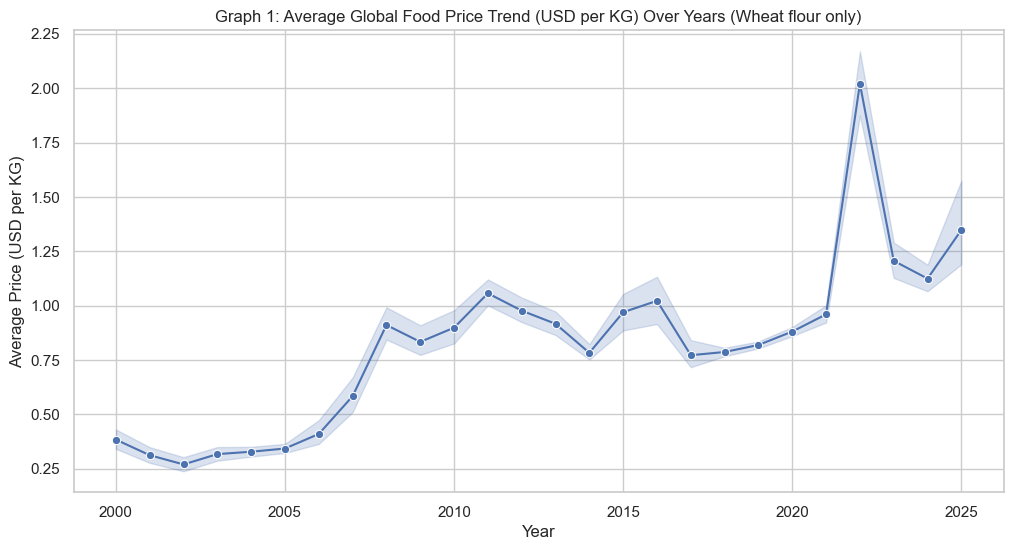


กำลังสร้าง กราฟที่ 2: เปรียบเทียบราคาสินค้า (Bar Plot)


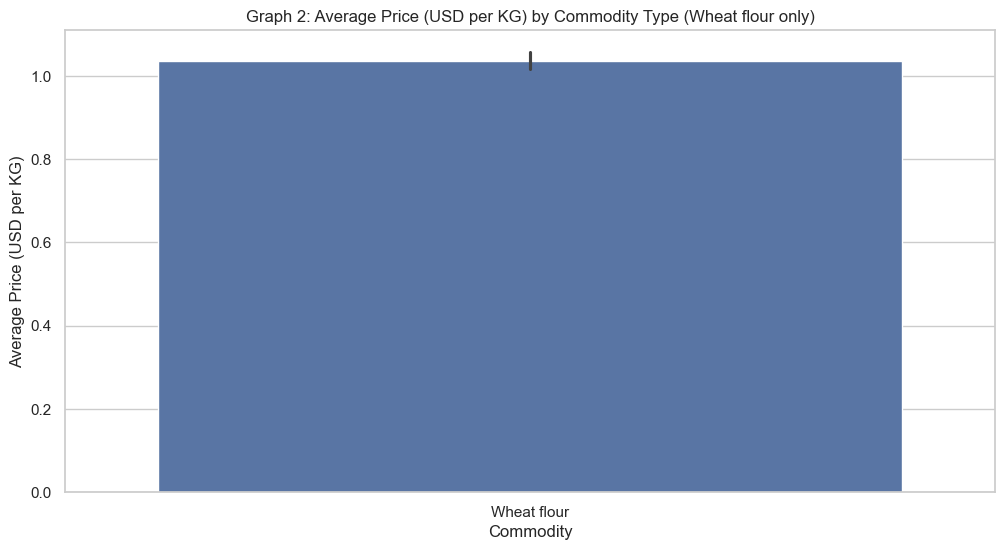


กำลังสร้าง กราฟที่ 3: การกระจายตัวของราคา (Box Plot) [แบบซ่อน Outliers]


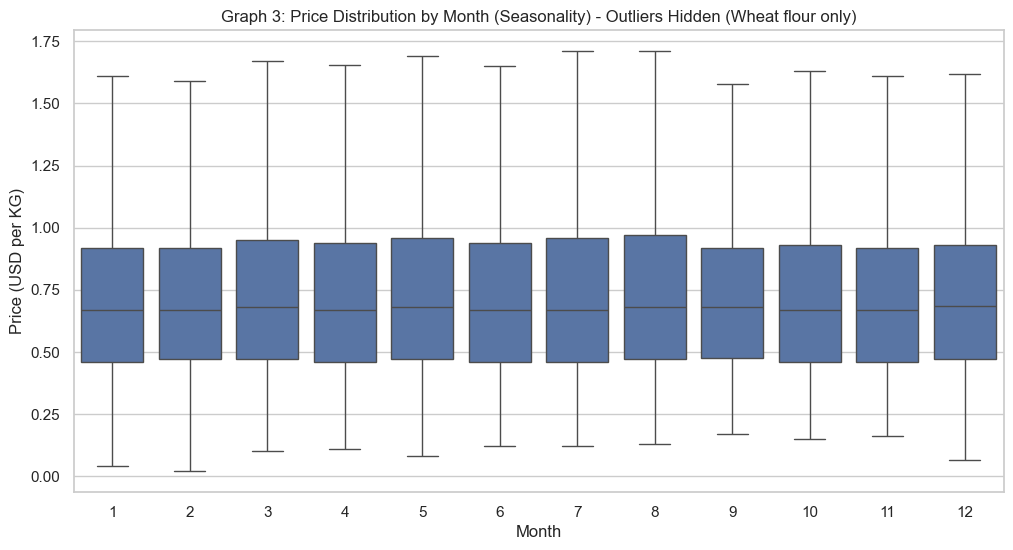

In [ ]:
# (ใน Cell 6: 58c9ed21)

import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- [ขั้นตอนที่ 6] เริ่มต้นการวิเคราะห์และสร้างกราฟ (Visualization) ---")

sns.set_theme(style="whitegrid")

try:
    print("กำลังสร้าง กราฟที่ 1: แนวโน้มราคาระยะยาว (Line Plot)")
    
    # --- [ 🔴 แก้ไข 🔴 ] ---
    # เปลี่ยนจาก 'price_usd' เป็น 'price_per_kg'
    df_yearly_price = df.groupby('Year')['price_per_kg'].mean().reset_index()
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    
    sns.lineplot(data=df, x='Year', y='price_per_kg', marker='o', ax=ax1)
    
    ax1.set_title('Graph 1: Average Global Food Price Trend (USD per KG) Over Years (Wheat flour only)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Price (USD per KG)')
    # ------------------------
    plt.show()
    
    print("\nกำลังสร้าง กราฟที่ 2: การกระจายตัวของราคา (Box Plot) [แบบซ่อน Outliers]")
    
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    
    # --- [ 🔴 แก้ไข 🔴 ] ---
    # เปลี่ยนจาก 'price_usd' เป็น 'price_per_kg'
    sns.boxplot(data=df, x='Month', y='price_per_kg', showfliers=False, ax=ax3) 
    
    ax3.set_title('Graph 2: Price Distribution by Month (Seasonality) - Outliers Hidden (Wheat flour only)')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Price (USD per KG)')
    # ------------------------
    plt.show()

except Exception as e:
    print(f"!!! เกิดข้อผิดพลาดระหว่างการสร้างกราฟ: {e}")
    print("!!! กรุณาตรวจสอบว่า DataFrame 'df' ยังอยู่ใน Memory")


--- [ขั้นตอนที่ 8] การสร้างกราฟทำนายอนาคต (ฉบับแก้ไข: ค่าเฉลี่ยรายปี) ---
กำลังเตรียมทำนายอนาคตของ: Wheat flour (เฉลี่ยรายปี) ... 5 ปีล่วงหน้า
กำลังสร้างกราฟทำนายอนาคต (รายปี)...


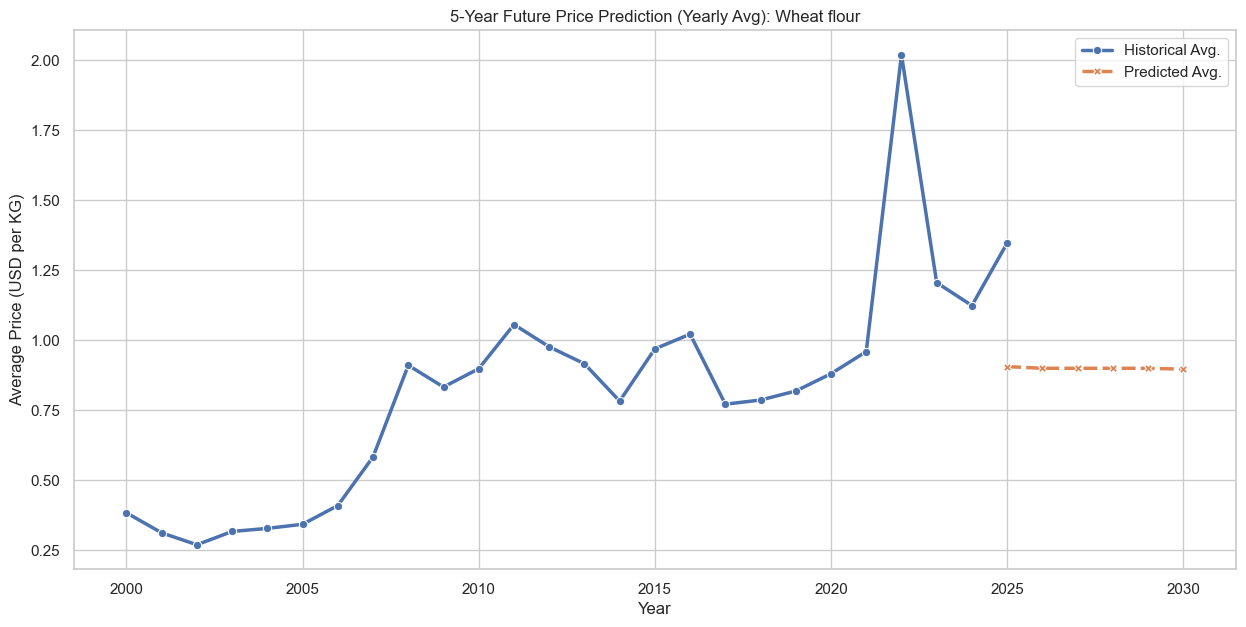

In [10]:
# (ใน Cell 8: 95c820bb)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

print("\n--- [ขั้นตอนที่ 8] การสร้างกราฟทำนายอนาคต (ฉบับแก้ไข: ค่าเฉลี่ยรายปี) ---")

commodity_to_predict = 'Wheat flour'

print(f"กำลังเตรียมทำนายอนาคตของ: {commodity_to_predict} (เฉลี่ยรายปี) ... 5 ปีล่วงหน้า")

try:
    # --- 1. สร้าง \"ตารางเวลาอนาคต\" (Future DataFrame) ---
    # (เหมือนเดิม) สร้างพิมพ์เขียว 60 เดือนข้างหน้า
    last_date = df['date'].max()
    future_periods = 60 
    future_dates = pd.date_range(start=last_date, periods=future_periods, freq='MS') 
    
    df_future = pd.DataFrame(0, index=future_dates, columns=X.columns)
    
    df_future['Year'] = df_future.index.year 
    df_future['Month'] = df_future.index.month
    df_future['Quarter'] = df_future.index.quarter
    
    # --- 2. ทำนายอนาคต (รายเดือน) ---
    # (เหมือนเดิม) โมเดลจะทำนาย price_per_kg ออกมา 60 ค่า (รายเดือน)
    future_predictions = best_tuned_model.predict(df_future)
    
    df_predictions_monthly = pd.DataFrame({
        'date': future_dates,
        'predicted_price_per_kg': future_predictions 
    })
    
    # --- [ 🔴 แก้ไข 🔴 ] ---
    # 3. สรุปผลการทำนาย (รายเดือน) ให้เป็น (รายปี)
    df_predictions_monthly['Year'] = df_predictions_monthly['date'].dt.year
    df_predictions_yearly = df_predictions_monthly.groupby('Year')['predicted_price_per_kg'].mean().reset_index()
    
    # 4. ดึงข้อมูล \"อดีต\" (Historical) และสรุปเป็น (รายปี)
    df_historical = df[df['commodity'] == commodity_to_predict]
    df_historical['Year'] = df_historical['date'].dt.year # (ต้องมีคอลัมน์ Year ก่อน)
    df_historical_yearly = df_historical.groupby('Year')['price_per_kg'].mean().reset_index()

    # 5. รวมข้อมูลอดีตและอนาคต (รายปี) เพื่อพล็อต
    # (เปลี่ยนชื่อคอลัมน์ให้เหมือนกันเพื่อง่ายต่อการพล็อต)
    df_hist_plot = df_historical_yearly.rename(columns={'price_per_kg': 'Price (USD per KG)'})
    df_hist_plot['Type'] = 'Historical Avg.'

    df_pred_plot = df_predictions_yearly.rename(columns={'predicted_price_per_kg': 'Price (USD per KG)'})
    df_pred_plot['Type'] = 'Predicted Avg.'

    df_combined_plot = pd.concat([df_hist_plot, df_pred_plot])
    # ------------------------

    # --- 6. สร้างกราฟ (รายปี) ---
    print("กำลังสร้างกราฟทำนายอนาคต (รายปี)...")
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # --- [ 🔴 แก้ไข 🔴 ] ---
    # พล็อตกราฟเส้นเดียวที่รวมทั้งอดีตและอนาคต (แบ่งตาม 'Type')
    sns.lineplot(data=df_combined_plot, 
                 x='Year', 
                 y='Price (USD per KG)', 
                 hue='Type', 
                 style='Type', 
                 markers=True, 
                 dashes=True, 
                 ax=ax,
                 linewidth=2.5)
    
    ax.set_title(f'5-Year Future Price Prediction (Yearly Avg): {commodity_to_predict}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Price (USD per KG)')
    # ------------------------
    
    ax.legend()
    plt.show()

except NameError as e:
    print(f"!!! Error: ไม่พบตัวแปร (เช่น 'X' หรือ 'best_tuned_model')")
    print("!!! กรุณารัน Cell 1-5 ให้ครบก่อน!!!")
except Exception as e:
    print(f"เกิดข้อผิดพลาด: {e}")